# Assess phenology of the phytoplankton bloom

In [8]:
import sys
import os

import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
import h5py as h5

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# regridding package
import xesmf as xe

# statistics package
import skill_metrics as sm


# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("h5py version =", h5.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("xesmf version =", xe.__version__)


wrkdir = "/g/data/es60/pjb581/liteexps"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.1
xarray version = 2023.6.0
scipy version = 1.12.0
h5py version = 3.9.0
matplotlib version = 3.8.0
cmocean version = v3.0.3
cartopy version = 0.22.0
xesmf version = 0.8.5


'/g/data/es60/pjb581/liteexps'

## load the model data (daily chlorophyll from WOMBAT-lite optimal run after 100 years)

In [10]:
mod_chl = xr.open_dataset("./lite2optim21/oceanbgc-2d-chlorophyll-1-daily-mean-y_1999.nc")['chlorophyll'].squeeze()

lon_mod = mod_chl.coords['xt_ocean']
lat_mod = mod_chl.coords['yt_ocean']
lons_mod, lats_mod = np.meshgrid(lon_mod.values, lat_mod.values)

### concatenate the daily chlorophyll data so that we have 2 years of data and assign a new time coordinate for this
new_time = pd.date_range(start='1998-01-01', end='1999-12-31', freq='D')
mod_chl = xr.concat([mod_chl, mod_chl], dim='time').assign_coords(time=new_time)


## Regrid the model output to a regular 0.5 x 0.5 degree grid

In [11]:
ds_out = xe.util.grid_global(0.5,0.5)
lon_reg = ds_out.coords['lon']
lat_reg = ds_out.coords['lat']

print("Regridding model")
ds_in = xr.Dataset(
    {'chl': ( ('time', 'y', 'x'), mod_chl.values),
     },
    coords={"lon": (['y','x'], lons_mod),
            "lat": (['y','x'], lats_mod),
            "time": (['time'], mod_chl.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
mod_chl = regridder(ds_in['chl'])


Regridding model


## plot some example phenology from the Subantarctic

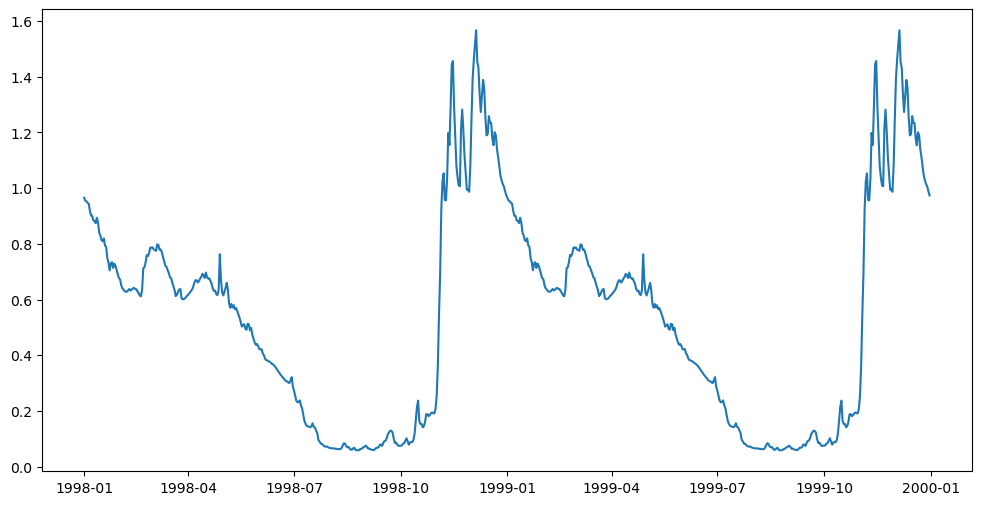

In [12]:
lon = -120.0
lat = -50.0
chl_plot = mod_chl.where((mod_chl.coords['lon'] > lon-0.5) & (mod_chl.coords['lon'] < lon+0.5) & \
                        (mod_chl.coords['lat'] > lat-0.5) & (mod_chl.coords['lat'] < lat+0.5), drop=True).mean(dim=['x','y'])


#chl_plot = mod_chl.isel(x=xx, y=yy)

plt.figure(figsize=(12,6))
plt.plot(chl_plot.coords['time'], chl_plot)


## Identify the maximum and secondary peaks of surface Chl-a from this daily data

In [13]:
peak_locs, peak_heights = sci.signal.find_peaks(chl_plot, height=chl_plot.min().values + 0.75*(chl_plot.max()-chl_plot.min()).values, distance=5, prominence=0.05*(chl_plot.max()-chl_plot.mean()).values)
peak_heights['peak_heights'][0]

1.4565846920013428

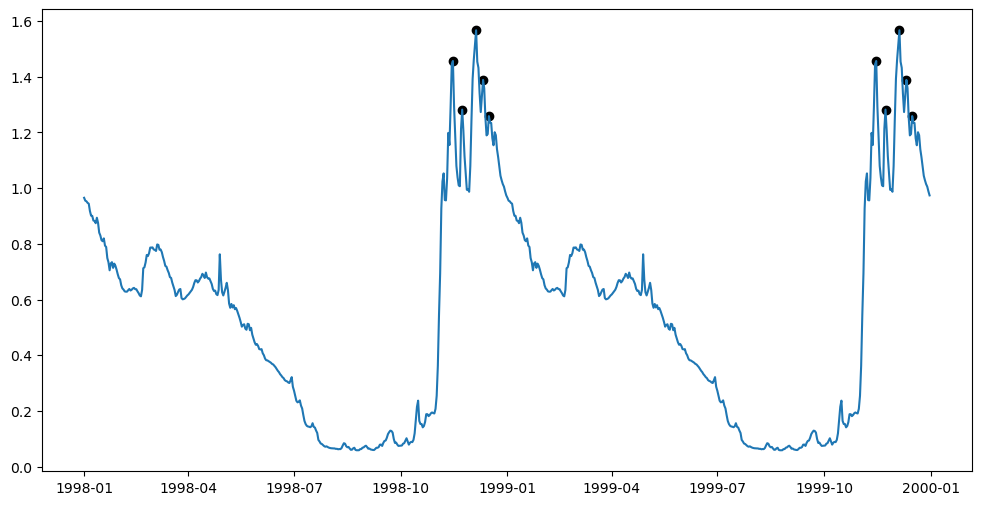

In [14]:
plt.figure(figsize=(12,6))
plt.plot(chl_plot.coords['time'], chl_plot)
plt.scatter(chl_plot.coords['time'][peak_locs], peak_heights['peak_heights'], color='k')

## identify the bloom slice (-3 and +3 months around peak bloom)

In [15]:
peak_times = chl_plot.time[peak_locs]
peak_times

<xarray.DataArray 'time' (time: 10)>
array(['1998-11-15T00:00:00.000000000', '1998-11-23T00:00:00.000000000',
       '1998-12-05T00:00:00.000000000', '1998-12-11T00:00:00.000000000',
       '1998-12-16T00:00:00.000000000', '1999-11-15T00:00:00.000000000',
       '1999-11-23T00:00:00.000000000', '1999-12-05T00:00:00.000000000',
       '1999-12-11T00:00:00.000000000', '1999-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1998-11-15 1998-11-23 ... 1999-12-16

In [16]:
def find_bloom_slice(chl_ts, peak_locs, peak_heights):
    if len(peak_locs) == 1:
        bloom_slice = chl_ts.isel(time=slice(peak_locs[0]-180, peak_locs[0]+180))
    else:
        ### find the peak times
        peak_times = chl_ts.time[peak_locs]
        ### get the time differential
        dt = np.diff(peak_times.values) / np.timedelta64(1,'D')
        ### find distinct clusters of peaks within 24 days of each other
        clusters = []
        peaksets = []
        current_cluster = [peak_locs[0]]
        current_peakset = [peak_heights[0]]
        for i, diff in enumerate(dt):
            if diff < 24:
                current_cluster.append(peak_locs[i+1])
                current_peakset.append(peak_heights[i+1])
            else:
                clusters.append(current_cluster)
                peaksets.append(current_peakset)
                current_cluster = [peak_locs[i+1]]
                current_peakset = [peak_heights[i+1]]
        clusters.append(current_cluster)
        peaksets.append(current_peakset)
        ### find the largest cluster and maximum productivity
        if len(clusters) == 1:
            bloom_slice = chl_ts.isel(time=slice(None,None))
        else:
            # Find the most productive peakset (the one with the highest sum of amplitudes)
            productivity = max(peaksets, key=sum)
            # Find the indices of the peakset with the highest productivity
            prod_index = peaksets.index(productivity)
            # Get the corresponding cluster (i.e., the time locations for the productive peakset)
            most_productive_cluster = clusters[prod_index]
            # Get the largest cluster (i.e., the place with the most peaks) 
            largest_cluster = max(clusters, key=len)

            ### if the most productive set of peaks is also the largest set of peaks, amazing...
            if (len(productivity) == len(largest_cluster)):
                if (largest_cluster[0] < 180.0):
                    largest_cluster = max(clusters[1::], key=len)
                if (largest_cluster[0] < 180.0):
                    largest_cluster = max(clusters[2::], key=len)
                bloom_slice = chl_ts.isel(time=slice(largest_cluster[0]-180, largest_cluster[-1]+180))
                ### otherwise, we chose the most productive set of peaks over the largest set
            else:
                bloom_slice = chl_ts.isel(time=slice(most_productive_cluster[0]-180, most_productive_cluster[-1]+180))
    
    return bloom_slice

bloom_slice = find_bloom_slice(chl_plot, peak_locs, peak_heights['peak_heights'])


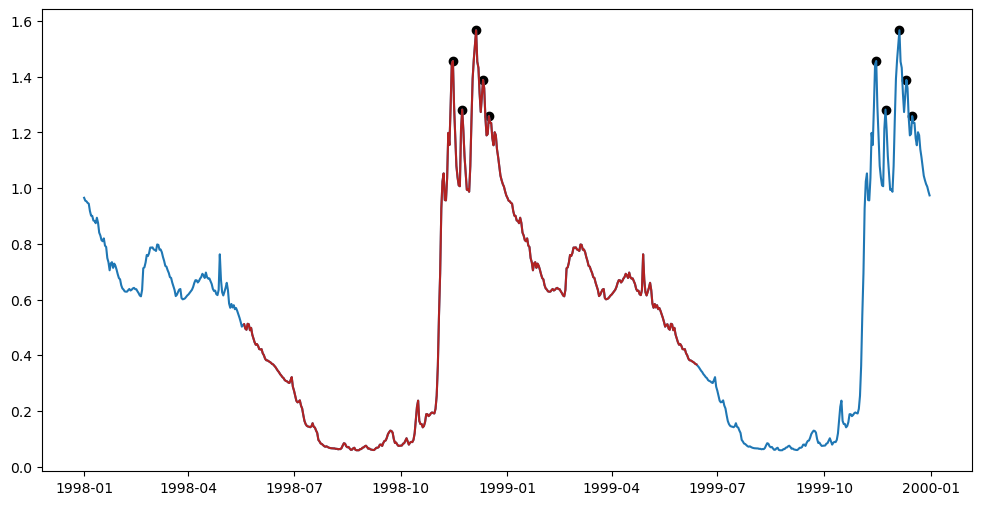

In [17]:
plt.figure(figsize=(12,6))
plt.plot(chl_plot.coords['time'], chl_plot)
plt.scatter(chl_plot.coords['time'][peak_locs], peak_heights['peak_heights'], color='k')
plt.plot(bloom_slice.coords['time'], bloom_slice, color='firebrick')

## find initiation of bloom

In [18]:
def find_bloom_initiation(bloom_slice):
    ### find start and end periods of bloom
    bloom_start = bloom_slice.isel(time=slice(0,180))
    bloom_end = bloom_slice.isel(time=slice(-180,-1))
    ### ensure that the start begins from a minimum
    indx_start = bloom_start.argmin().item()
    bloom_start = bloom_start.sel(time=slice(bloom_start.time[indx_start], None))
    indx_end = bloom_end.argmin().item()
    bloom_end = bloom_end.sel(time=slice(bloom_end.time[0], bloom_end.time[indx_end]))
    
    ### Threshold method
    min_val1 = bloom_start.min().values
    min_val2 = bloom_end.min().values
    threshold1 = min_val1 * 1.05
    threshold2 = min_val2 * 1.05
    init_1 = bloom_start.where(bloom_start > threshold1, drop=True).time[0]
    term_1 = bloom_end.where(bloom_end < threshold2, drop=True).time[0]

    ### Cumulative method
    med_val1 = bloom_start.median().values
    med_val2 = bloom_end.median().values
    bloom_cumsum1 = bloom_start.cumsum(dim='time')
    bloom_cumsum2 = bloom_end[::-1].cumsum(dim='time')
    threshold1 = bloom_cumsum1[-1].values * 0.15
    threshold2 = bloom_cumsum2[-1].values * 0.15
    init_2 = bloom_start.where(bloom_cumsum1 > threshold1, drop=True).time[0]
    term_2 = bloom_end[::-1].where(bloom_cumsum2 > threshold2, drop=True).time[0]

    ### Rate of change method
    dc1 = np.diff(bloom_start.values)
    dt1 = np.diff(bloom_start.time.values) / np.timedelta64(1,'D')
    dc2 = np.diff(bloom_end.values)
    dt2 = np.diff(bloom_end.time.values) / np.timedelta64(1,'D')
    med_rate1 = np.median(dc1 / dt1)
    med_rate2 = np.median(dc2 / dt2)
    threshold1 = med_rate1 * 0.15
    threshold2 = med_rate2 * 0.15
    dcdt_threshold1 = np.where(dc1/dt1 > threshold1)[0]
    dcdt_threshold2 = np.where(-dc2/dt2 > threshold2)[0]
    if len(dcdt_threshold1) > 0:
        init_3 = bloom_start.time[dcdt_threshold1[0]].values
    else:
        init_3 = None # If no points meet the criteria
    if len(dcdt_threshold2) > 0:
        term_3 = bloom_end.time[dcdt_threshold2[-1]].values
    else:
        term_3 = None # If no points meet the criteria


    return [init_1, term_1], [init_2, term_2], [init_3, term_3]

ts, cs, rc = find_bloom_initiation(bloom_slice)

print(f"Initiation based on 5% above minimum (Threshold method): {ts[0]}")
print(f"Initiation based on 15% cumulative sum (Cumulative sum method): {cs[0]}")
print(f"Initiation based on rate of increase (Rate of change method): {rc[0]}")

print(f"Termination based on 5% above minimum (Threshold method): {ts[1]}")
print(f"Termination based on 15% cumulative sum (Cumulative sum method): {cs[1]}")
print(f"Termination based on rate of increase (Rate of change method): {rc[1]}")

Initiation based on 5% above minimum (Threshold method): <xarray.DataArray 'time' ()>
array('1998-08-27T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1998-08-27
Initiation based on 15% cumulative sum (Cumulative sum method): <xarray.DataArray 'time' ()>
array('1998-10-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1998-10-01
Initiation based on rate of increase (Rate of change method): 1998-08-26T00:00:00.000000000
Termination based on 5% above minimum (Threshold method): <xarray.DataArray 'time' ()>
array('1999-06-07T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1999-06-07
Termination based on 15% cumulative sum (Cumulative sum method): <xarray.DataArray 'time' ()>
array('1999-05-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1999-05-05
Termination based on rate of increase (Rate of change method): 1999-06-11T00:00:00.00000

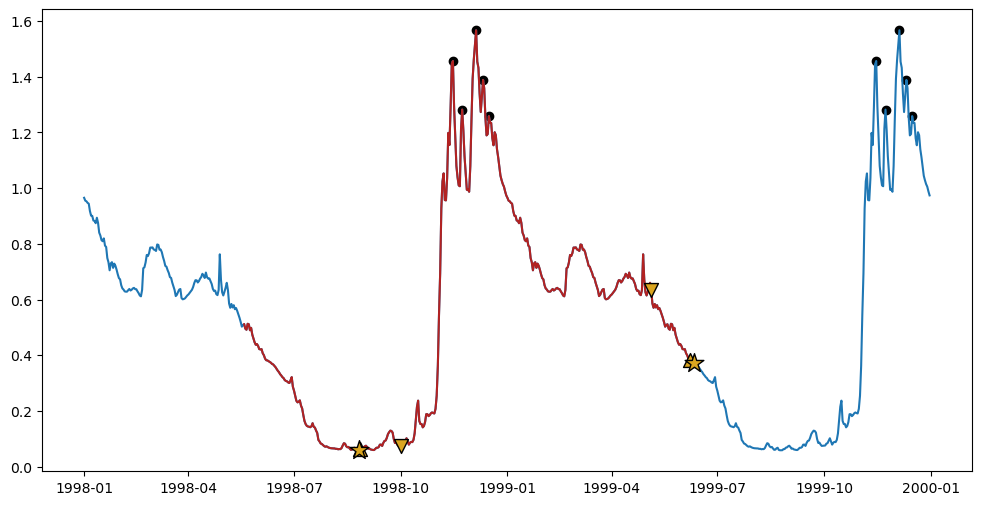

In [19]:
plt.figure(figsize=(12,6))
plt.plot(chl_plot.coords['time'], chl_plot)
plt.scatter(chl_plot.coords['time'][peak_locs], peak_heights['peak_heights'], color='k')
plt.plot(bloom_slice.coords['time'], bloom_slice, color='firebrick')
plt.scatter(ts[0], chl_plot.sel(time=ts[0]), marker='^', color='goldenrod', edgecolor='k', s=100, zorder=3)
plt.scatter(cs[0], chl_plot.sel(time=cs[0]), marker='v', color='goldenrod', edgecolor='k', s=100, zorder=3)
plt.scatter(rc[0], chl_plot.sel(time=rc[0]), marker='*', color='goldenrod', edgecolor='k', s=200, zorder=3)
plt.scatter(ts[1], chl_plot.sel(time=ts[1]), marker='^', color='goldenrod', edgecolor='k', s=100, zorder=3)
plt.scatter(cs[1], chl_plot.sel(time=cs[1]), marker='v', color='goldenrod', edgecolor='k', s=100, zorder=3)
plt.scatter(rc[1], chl_plot.sel(time=rc[1]), marker='*', color='goldenrod', edgecolor='k', s=200, zorder=3)


## get the duration of the bloom, the sum and mean of the chlorophyll-a over the duration

In [20]:
def find_duration_sum_mean(bloom_slice, ts, cs, rc, method="None"):
    ### duration of bloom
    ts_dura = ((ts[1] - ts[0]) / np.timedelta64(1,'D')).values
    cs_dura = ((cs[1] - cs[0]) / np.timedelta64(1,'D')).values
    rc_dura = ((rc[1] - rc[0]) / np.timedelta64(1,'D'))
    ### integrated sum of chlorophyll-a
    ts_sum = bloom_slice.sel(time=slice(ts[0], ts[1])).sum().values
    cs_sum = bloom_slice.sel(time=slice(cs[0], cs[1])).sum().values
    rc_sum = bloom_slice.sel(time=slice(rc[0], rc[1])).sum().values
    ### mean of chlorophyll-a
    ts_ave = bloom_slice.sel(time=slice(ts[0], ts[1])).mean().values
    cs_ave = bloom_slice.sel(time=slice(cs[0], cs[1])).mean().values
    rc_ave = bloom_slice.sel(time=slice(rc[0], rc[1])).mean().values
    if method == "None" or method == "TS":
        return ts_dura, ts_sum, ts_ave
    elif method == "CS":
        return cs_dura, cs_sum, cs_ave
    elif method == "RC":
        return rc_dura, rc_sum, rc_ave
    else:
        print('Please specific one of "TS", "CS" or "RC" as methods')
        
print(find_duration_sum_mean(bloom_slice, ts, cs, rc, method="CS"))


(array(216.), array(162.13089, dtype=float32), array(0.74714696, dtype=float32))


## let's repeat the above but do so globally, saving initiation dates, duration, mean and sum chlorophyll of the bloom

In [ ]:
%%time
### initialize the arrays to save the data to
array_shape = np.shape(mod_chl[0,:,:])

duration = np.zeros(array_shape)*np.nan
initiation = np.zeros(array_shape)*np.nan
mean_chla = np.zeros(array_shape)*np.nan
sum_chla = np.zeros(array_shape)*np.nan

### iterate over the grid
for xx in np.arange(array_shape[-1]):
    for yy in np.arange(array_shape[0]):

        if (yy == 0) & (xx%50 == 0):
            print(xx)
        
        chl = mod_chl.isel(x=xx, y=yy)
        if chl.isnull().all() == True:
            continue
        
        # minimum amplitude of peaks must be greater then 75% of the max value
        min_amp = chl.min().values + 0.75*(chl.max()-chl.min()).values
        # minimum prominance of the peaks must be greater then 5% of difference between the mean and max value
        min_prom = 0.05*(chl.max()-chl.mean()).values
        peak_locs, peak_heights = sci.signal.find_peaks(chl, height=min_amp, distance=5, prominence=min_prom)
        bloom_slice = find_bloom_slice(chl, peak_locs, peak_heights['peak_heights'])
        if bloom_slice.size == 0:
            continue
        
        ts, cs, rc = find_bloom_initiation(bloom_slice)
        initiation[yy,xx] = pd.Timestamp(rc[0]).day_of_year
        duration[yy,xx], sum_chla[yy,xx], mean_chla[yy,xx] = find_duration_sum_mean(bloom_slice, ts, cs, rc, method="CS")



0


### save this dataset to disk

In [64]:
ds = xr.Dataset(
    {
        "initiation": (['lat', 'lon'], initiation),
        "duration": (['lat', 'lon'], duration),
        "sum_chla": (['lat', 'lon'], sum_chla),
        "ave_chla": (['lat', 'lon'], mean_chla),
    },
    coords={
        "lat": lat_reg.isel(x=0).values,
        "lon": lon_reg.isel(y=0).values,
    }
)

ds.to_netcdf("lite2optim21_chla_phenology_CumulativeSum.nc")

### get this dataset

In [4]:
ds = xr.open_dataset("lite2optim21_chla_phenology_CumulativeSum.nc")
ds

<xarray.Dataset>
Dimensions:     (lat: 360, lon: 720)
Coordinates:
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    initiation  (lat, lon) float64 ...
    duration    (lat, lon) float64 ...
    sum_chla    (lat, lon) float64 ...
    ave_chla    (lat, lon) float64 ...

## get the data from Nicholson et al. 2024, which makes these calculations on the OC-CCI composite chlorophyll concentration data

In [5]:
phenology = xr.open_dataset("../../observations/OCCCIv6_25KM_PHENOLOGY_CHLOR_A.nc", decode_times=True)
obs_duration = phenology['duration_cs'].mean(dim='year') / np.timedelta64(1,'D')
obs_sum_chla = phenology['int_chl_cs'].mean(dim='year')
obs_ave_chla = phenology['mean_chl_cs'].mean(dim='year')

### have to normalised the initiation dates to the start of each respective year
obs_init_norm = np.zeros((25,720,1440))
reference_date = np.datetime64('1998-11-25')
for yy,yr in enumerate(np.arange(1998,2023,1)):
    reference_date = np.datetime64('%i-01-01'%(yr))
    obs_init = phenology['initiation_rc'].isel(year=yy)
    obs_init_norm[yy,:,:] = ((obs_init - reference_date) / np.timedelta64(1,'D')).values
obs_init_norm = np.nanmean(obs_init_norm,axis=0)

phen_lon, phen_lat = np.meshgrid(obs_duration.coords['lon'], obs_duration.coords['lat'])
'''
ds_in = xr.Dataset(
    {'obs_duration': ( ('year', 'y', 'x'), obs_duration.values),
     'obs_initiation': ( ('year', 'y', 'x'), obs_initiation.values),
     'obs_sum_chla': ( ('year', 'y', 'x'), obs_sum_chla.values),
     'obs_ave_chla': ( ('year', 'y', 'x'), obs_ave_chla.values),
     },
    coords={"lon": (['y','x'], phen_lon),
            "lat": (['y','x'], phen_lat),
            "year": (['year'], np.arange(1998,2023,1)),
            }
    )
'''
ds_in = xr.Dataset(
    {'obs_duration': ( ('y', 'x'), obs_duration.values),
     'obs_initiation': ( ('y', 'x'), obs_init_norm),
     'obs_sum_chla': ( ('y', 'x'), obs_sum_chla.values),
     'obs_ave_chla': ( ('y', 'x'), obs_ave_chla.values),
     },
    coords={"lon": (['y','x'], phen_lon),
            "lat": (['y','x'], phen_lat),
            }
    )

print("Regridding")
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d', ignore_degenerate=True)
obs_duration = regridder(ds_in['obs_duration'])
obs_initiation = regridder(ds_in['obs_initiation'])
obs_sum_chla = regridder(ds_in['obs_sum_chla'])
obs_ave_chla = regridder(ds_in['obs_ave_chla'])


/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/g/data/es60/pjb581/miniforg

Regridding


<xarray.DataArray (y: 360, x: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat      (y, x) float64 -89.75 -89.75 -89.75 -89.75 ... 89.75 89.75 89.75
    lon      (y, x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Dimensions without coordinates: y, x

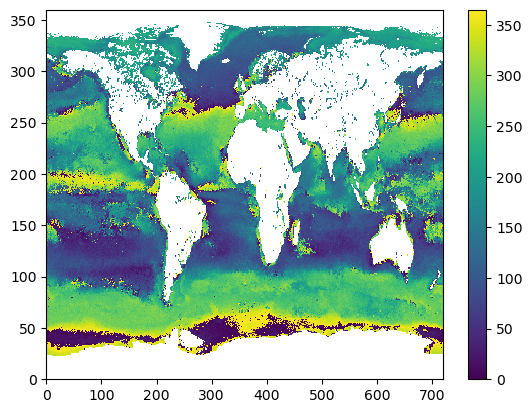

In [6]:
### ensure that values beneath 0, and those above 365, cycle back into the year
obs_initiation = xr.where(obs_initiation < 0.0, obs_initiation + 365, obs_initiation)
obs_initiation = xr.where(obs_initiation > 365, obs_initiation - 365, obs_initiation)

plt.figure()
plt.pcolormesh(obs_initiation)
plt.colorbar()
obs_initiation

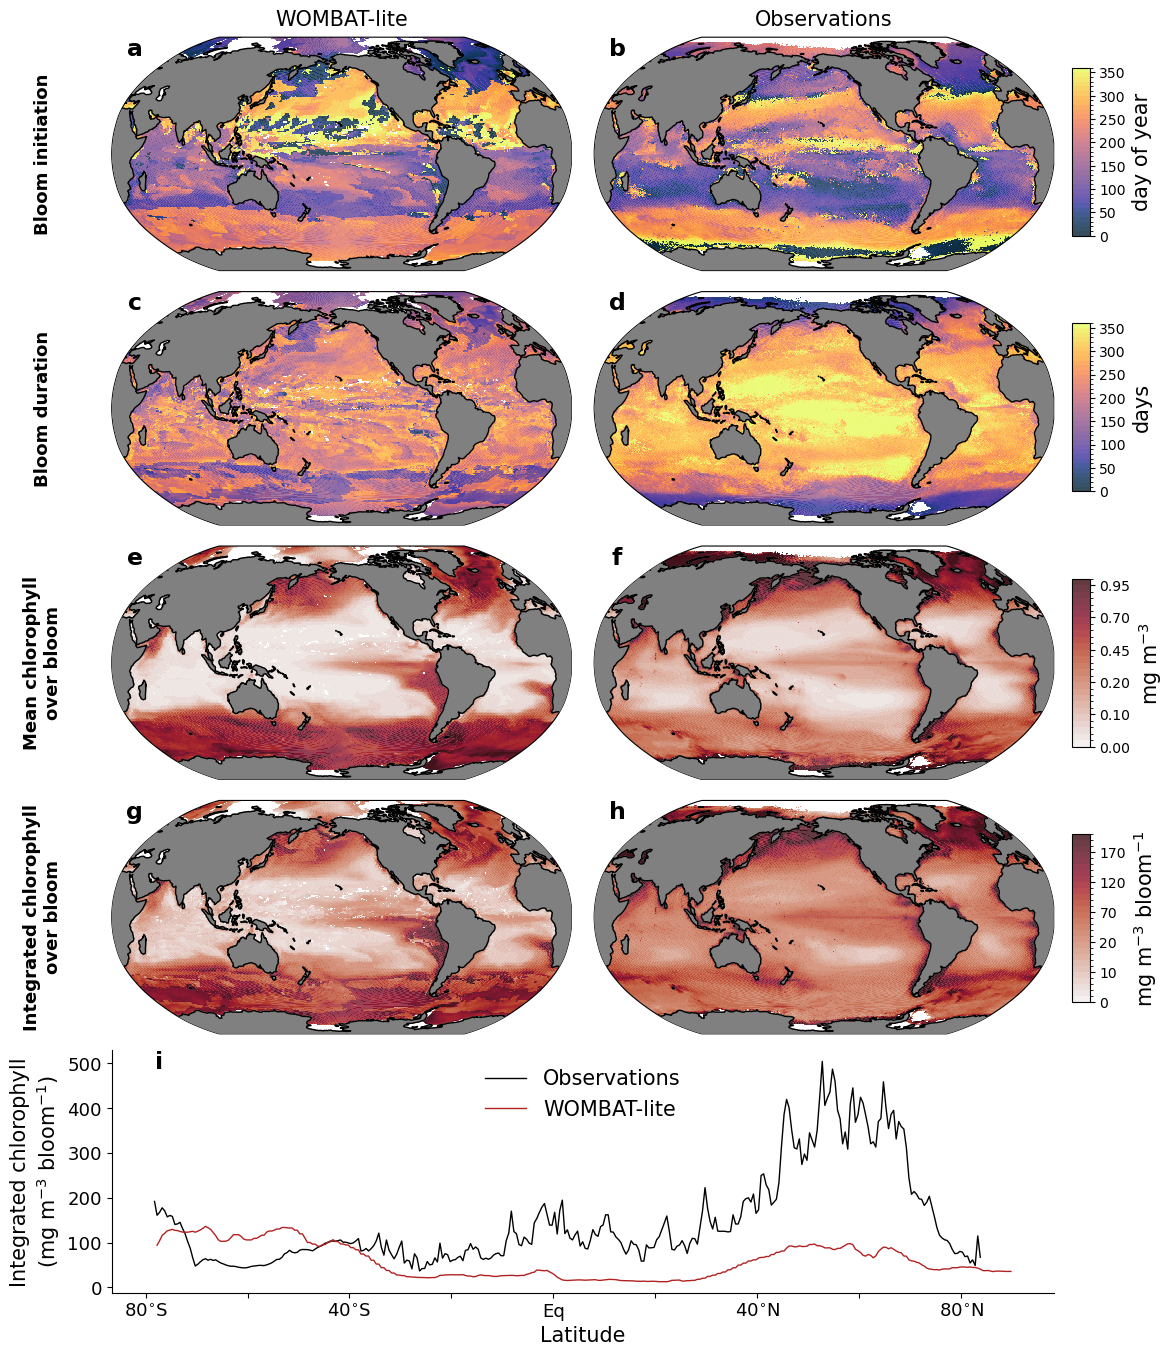

In [7]:
fslab = 15
fstic = 13

import matplotlib.lines as mlines
from cartopy.util import add_cyclic_point

proj = ccrs.Robinson(central_longitude=205)

colmap1 = lighten(cmo.thermal, 0.8) #Initiation
colmap2 = lighten(cmo.thermal, 0.8) #Duration
colmap3 = lighten(cmo.amp, 0.8) #mean
colmap4 = lighten(cmo.amp, 0.8) #sum

# Initiation
levs1 = np.arange(0,365,10)
norm1 = mcolors.BoundaryNorm(levs1, ncolors=256)

# Duration
levs2 = np.arange(0,365,10)
norm2 = mcolors.BoundaryNorm(levs2, ncolors=256)

# Mean
levs3 = np.concatenate( (np.arange(0,20,2), np.arange(20,101,5)) )*0.01
norm3 = mcolors.BoundaryNorm(levs3, ncolors=256)

# Sum
levs4 = np.concatenate( (np.arange(0,20,2), np.arange(20,201,10)) )
norm4 = mcolors.BoundaryNorm(levs4, ncolors=256)


fig = plt.figure(figsize=(12,14), facecolor='w')
gs = GridSpec(5, 2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[1,0], projection=proj)
ax4 = plt.subplot(gs[1,1], projection=proj)
ax5 = plt.subplot(gs[2,0], projection=proj)
ax6 = plt.subplot(gs[2,1], projection=proj)
ax7 = plt.subplot(gs[3,0], projection=proj)
ax8 = plt.subplot(gs[3,1], projection=proj)
ax9 = plt.subplot(gs[4,:])

ax9.tick_params(labelsize=fstic)

ax9.spines[['top','right']].set_visible(False)

p1 = ax1.pcolormesh(lon_reg.isel(y=0), lat_reg.isel(x=0), ds['initiation'], transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1)
p2 = ax2.pcolormesh(lon_reg.isel(y=0), lat_reg.isel(x=0), obs_initiation, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1)

p3 = ax3.pcolormesh(lon_reg.isel(y=0), lat_reg.isel(x=0), ds['duration'], transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2)
p4 = ax4.pcolormesh(lon_reg.isel(y=0), lat_reg.isel(x=0), obs_duration, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2)

p5 = ax5.pcolormesh(lon_reg.isel(y=0), lat_reg.isel(x=0), ds['ave_chla'], transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3)
p6 = ax6.pcolormesh(lon_reg.isel(y=0), lat_reg.isel(x=0), obs_ave_chla, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3)

p7 = ax7.pcolormesh(lon_reg.isel(y=0), lat_reg.isel(x=0), ds['sum_chla'], transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4)
p8 = ax8.pcolormesh(lon_reg.isel(y=0), lat_reg.isel(x=0), obs_sum_chla, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4)

ax9.plot(lat_reg.isel(x=0), obs_sum_chla.mean(dim='x'), color='k', linewidth=1, linestyle='-', alpha=1.0, label='Observations') 
ax9.plot(lat_reg.isel(x=0), ds['sum_chla'].mean(dim='lon'), color='firebrick', linewidth=1, linestyle='-', alpha=1.0, label='WOMBAT-lite')

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax3.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax4.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax4.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)

xx = -0.15; yy = 0.5
plt.text(xx,yy, 'Bloom initiation', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax1.transAxes)
plt.text(xx,yy, 'Bloom duration', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax3.transAxes)
plt.text(xx,yy, 'Mean chlorophyll\nover bloom', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax5.transAxes)
plt.text(xx,yy, 'Integrated chlorophyll\nover bloom', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax7.transAxes)

plt.text(0.5, 1.075, 'WOMBAT-lite', va='center', ha='center', fontsize=fslab, transform=ax1.transAxes)
plt.text(0.5, 1.075, 'Observations', va='center', ha='center', fontsize=fslab, transform=ax2.transAxes)

plt.subplots_adjust(left=0.1, bottom=0.05, top=0.95, right=0.885, hspace=0.05, wspace=0.05)


cbax1 = fig.add_axes([0.9, 0.8050, 0.015, 0.12])
cbax2 = fig.add_axes([0.9, 0.6225, 0.015, 0.12])
cbax3 = fig.add_axes([0.9, 0.4400, 0.015, 0.12])
cbax4 = fig.add_axes([0.9, 0.2575, 0.015, 0.12])

cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5])
cbar2 = plt.colorbar(p3, cax=cbax2, orientation='vertical', ticks=levs2[::5])
cbar3 = plt.colorbar(p5, cax=cbax3, orientation='vertical', ticks=levs3[::5])
cbar4 = plt.colorbar(p7, cax=cbax4, orientation='vertical', ticks=levs4[::5])

cbar1.ax.set_ylabel('day of year', fontsize=fslab)
cbar2.ax.set_ylabel('days', fontsize=fslab)
cbar3.ax.set_ylabel('mg m$^{-3}$', fontsize=fslab)
cbar4.ax.set_ylabel('mg m$^{-3}$ bloom$^{-1}$', fontsize=fslab)

xx = 0.05
yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, 'c', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax3.transAxes)
plt.text(xx,yy, 'd', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax4.transAxes)
plt.text(xx,yy, 'e', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax5.transAxes)
plt.text(xx,yy, 'f', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax6.transAxes)
plt.text(xx,yy, 'g', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax7.transAxes)
plt.text(xx,yy, 'h', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax8.transAxes)
plt.text(xx,yy, 'i', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax9.transAxes)

ax9.set_xlabel("Latitude", fontsize=fslab)
ax9.set_ylabel("Integrated chlorophyll\n(mg m$^{-3}$ bloom$^{-1}$)", fontsize=fslab)
ax9.legend(frameon=False, loc='upper center', ncol=1, fontsize=fslab)
ax9.set_xticks(np.arange(-80,81,20), np.array(['80$^{\circ}$S', '', '40$^{\circ}$S', '', 'Eq', '', '40$^{\circ}$N', '', '80$^{\circ}$N']))

os.chdir(wrkdir)
fig.savefig("figures/section3.4-phenology_CS.png", dpi=300)
fig.savefig("figures/section3.4-phenology_CS.pdf", dpi=300)
fig.savefig("figures/section3.4-phenology_CS_transparent.png", dpi=300, transparent=True)
